In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd

In [8]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [10]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
#measurement_first_row = session.query(measurement).first()
#measurement_first_row.__dict__

In [15]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Need to inspect the columns better visually
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(engine)

# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#latest date query - 10-Advanced-Data-Storage-and-Retrieval/3/Activities/02-Ins_Dates/Solved/Ins_Dates.ipynb
last_12_mths = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_12_mths

('2017-08-23')

In [20]:
# # Calculate the date 1 year ago from the last data point in the database
last_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Last Year Date: ", last_year_date)

Last Year Date:  2016-08-23


In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#latest date query - 10-Advanced-Data-Storage-and-Retrieval/3/Activities/02-Ins_Dates/Solved/Ins_Dates.ipynb
#last_12_mths = session.query(measurement.date).order_by(measurement.date.desc()).first()

last_12_mnth_prcp = session.query(measurement.date, measurement.prcp).\
 filter(measurement.date >= last_year_date).order_by(measurement.date.desc()).all()
last_12_mnth_prcp

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_mnth_prcp_df = pd.DataFrame(last_12_mnth_prcp, columns = ['date','prcp'])
last_12_mnth_prcp_df.set_index('date', inplace=True)
last_12_mnth_prcp_df

# Sort the dataframe by date
last_12_mnth_prcp_df = last_12_mnth_prcp_df.sort_values(by=['date'], ascending=False)
last_12_mnth_prcp_df.head(10)
# Use Pandas Plotting with Matplotlib to plot the data


,prcp
date,
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-23,0.00
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


Text(0.5, 0, 'Date of Precipitation')

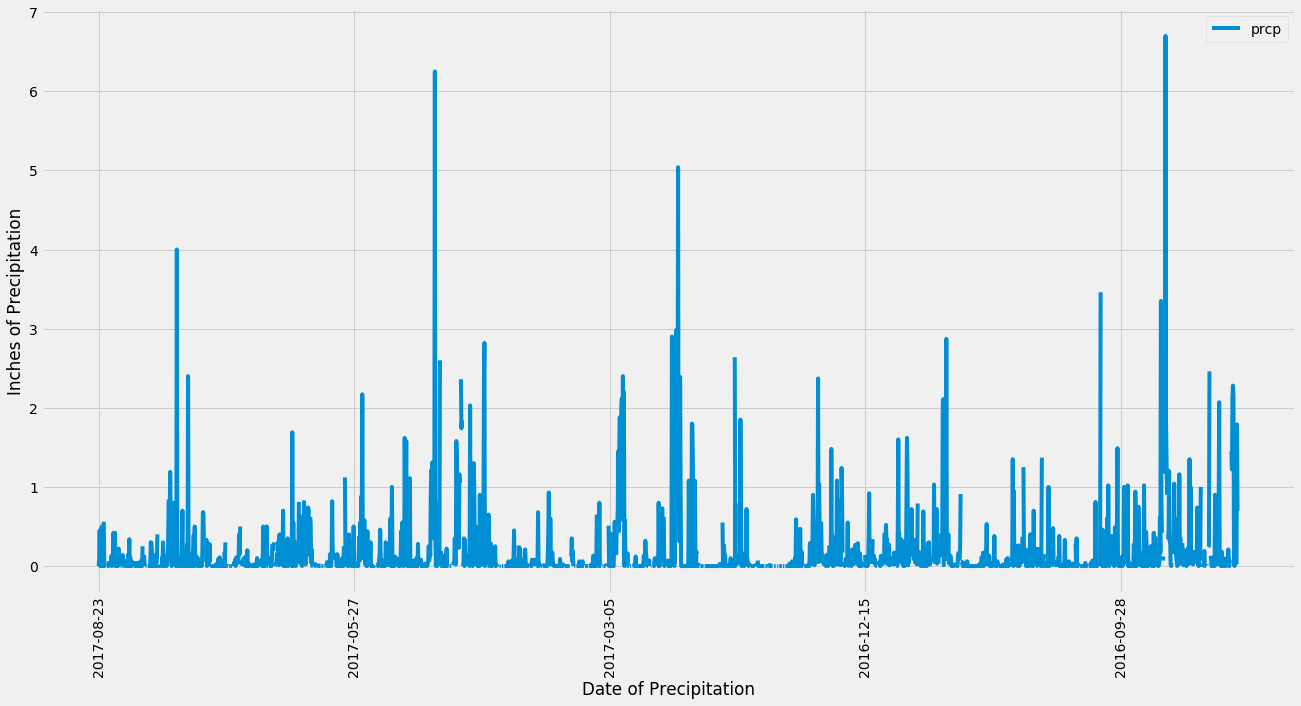

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12_mnth_prcp_df.plot(figsize=(20, 10), rot=90)
plt.ylabel("Inches of Precipitation")
plt.xlabel("Date of Precipitation")


In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_mnth_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [24]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(station.station).count()
print("The number of stations available in Hawaii are: ", num_stations)

The number of stations available in Hawaii are:  9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
    filter(measurement.station == station.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
most_station_id = most_active_stations[0][0]
print(f"The station with the most active: {most_station_id}.")

The station with the most active: USC00519281.


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()
print(f" The lowest temp, highest temp and avg temp recorded for the most active station USC00519281 is:", station_temp)

 The lowest temp, highest temp and avg temp recorded for the most active station USC00519281 is: [(54.0, 85.0, 71.66378066378067)]


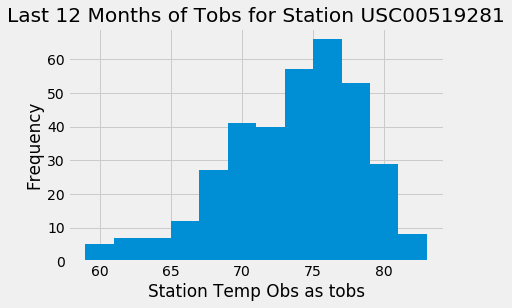

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_high_temp_ob = session.query(measurement.tobs).\
filter(measurement.station == "USC00519281").\
filter(measurement.date >= "2016-08-23").all()

data = pd.DataFrame(station_high_temp_ob, columns = ['tobs'])

plt.hist(data['tobs'], bins=12)
plt.xlabel('Station Temp Obs as tobs')
plt.ylabel('Frequency')
plt.title('Last 12 Months of Tobs for Station USC00519281')

plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [29]:
# measurements and stations data files
loadm_file = "hawaii_measurements.csv"
loads_file = "hawaii_stations.csv"

# Read the data files 
loadm_file = pd.read_csv(loadm_file)
loads_file = pd.read_csv(loads_file)

#Combine Data into a single file
merged_df = pd.merge(loadm_file, loads_file, on='station', how="outer")
merged_df

Temp_df = pd.DataFrame(merged_df)
Temp_df.columns = ['STATION', 'DATE', 'PRCP', 'TOBS', 'NAME', 'LATITUDE', 'LONGITUDE','ELEVATION']
Temp_df.head()

,STATION,DATE,PRCP,TOBS,NAME,LATITUDE,LONGITUDE,ELEVATION
0,USC00519397,2010-01-01,0.08,65,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [30]:
#EXTRACT THE MONTH AND YEAR FROM DATEFRAME 
#https://kanoki.org/2019/10/09/working-with-pandas-datetime/
Temp_df['DATE']=pd.to_datetime(Temp_df['DATE'])

Temp_df['Year']=Temp_df['DATE'].dt.year
Temp_df['month']=Temp_df['DATE'].dt.month
Temp_df['day']=Temp_df['DATE'].dt.day

#EXTRACT THE MONTH OF JUNE AND YEAR FROM DATEFRAME WITH MEAN 
print(f"The average temperature in June at all stations across all available years in the dataset: ")
avg_temp_june = Temp_df.loc[(Temp_df['DATE'].dt.month == 6)]
June_mean = avg_temp_june['TOBS'].mean()
print('mean: ' + str(June_mean))

The average temperature in June at all stations across all available years in the dataset: 
mean: 74.94411764705882


In [31]:
#EXTRACT THE MONTH OF DECEMBER AND YEAR FROM DATEFRAME WITH MEAN 
print(f"The average temperature in December at all stations across all available years in the dataset: ")
avg_temp_dec = Temp_df.loc[(Temp_df['DATE'].dt.month == 12)]
Dec_mean = avg_temp_dec['TOBS'].mean()
print('mean: ' + str(Dec_mean))

The average temperature in December at all stations across all available years in the dataset: 
mean: 71.04152933421226


In [32]:
#Test whether variances are equal
np.var(avg_temp_june) == np.var(avg_temp_dec)

PRCP         False
TOBS         False
LATITUDE     False
LONGITUDE    False
ELEVATION    False
Year         False
month         True
day          False
dtype: bool

In [34]:
# from scipy import stats
# june_data = stats.norm.rvs(loc=5, scale=10,size=500)
# dec_data = stats.norm.rvs(loc=5, scale=10,size=500)
# scipy.stats.ttest_ind(June_mean, Dec_mean)

In [35]:
# https://towardsdatascience.com/hypothesis-testing-how-to-determine-significance-ce3991c5db53
# Perfom the Welch t-test to determine if there is a significant difference in the dataset for June and December
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

####### stat.f_oneway(avg_temp_june, avg_temp_dec, equal_var=FALSE)

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-05-05', '2016-05-11'))

[(66.0, 72.07142857142857, 77.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps('2016-05-05', '2016-05-11')
print(trip_temps)

[(66.0, 72.07142857142857, 77.0)]


In [38]:
trip_temp_df = pd.DataFrame(trip_temps, columns=['tmin','tavg','tmax'])
trip_temp_df

,tmin,tavg,tmax
0,66.0,72.071429,77.0


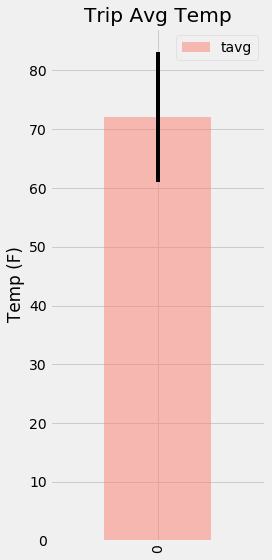

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.07-Error-Bars/

trip_temp_df = pd.DataFrame(trip_temps, columns=['tmin','tavg','tmax'])
trip_temp_df

yerr = trip_temp_df['tmax'] - trip_temp_df['tmin']
y = 'tvag'

bar = trip_temp_df.plot(kind='bar', y='tavg', yerr=yerr, alpha=0.5, color='salmon', figsize=plt.figaspect(2.))
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


total_rainfall_ws = session.query(station.station, 
                                   station.name, 
                                   station.latitude, 
                                   station.longitude, 
                                   station.elevation, 
                                   func.sum(measurement.prcp)).\
                                   filter(measurement.date >= '2017-01-01').\
                                   filter(measurement.date <= '2018-01-01').\
                                   group_by(station.station).\
                                   order_by(func.sum(measurement.prcp).desc()).all()
total_rainfall_ws

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  210.23000000000033),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  210.23000000000033),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  210.23000000000033),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  210.23000000000033),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  210.23000000000033),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  210.23000000000033),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  210.23000000000033),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  210.23000000000033),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  210.23000000000033)]

In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#https://www.geeksforgeeks.org/python-pandas-date_range-method/
daily_start = '2018-01-01'
daily_end = '2018-01-07'

# Use the start and end date to create a range of dates
range_of_dates = pd.date_range(start=daily_start,  end=daily_end)
range_of_dates
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
